In [69]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import json


kaggle_input_dir='/kaggle/input/'


# Filter columns to keep only the relevant metrics
columns_to_keep = [
    'Virtual Memory Load [%]',
    'Physical Memory Load [%]',
    # 'GPU Memory Usage [%]',
    'Total CPU Usage [%]',
    'GPU Total Usage [%]',
    'GPU GT Usage [%]',
    'Total Activity [%]',
    # 'GPU Computing Usage [%]',
    # 'GPU Core Load [%]',
    
    'GPU Power [W]',
    'PL1 Power Limit (Static) [W]',
    'PL1 Power Limit (Dynamic) [W]',
    # 'IGPU Power [W]',
    'CPU Package Power [W]',
    # 'PCH Power [W]',
    # 'Total DRAM Power [W]',
    # 'Core Effective Clocks (avg) [MHz]',
    'GPU Clock [MHz]',
    'Core Clocks (avg) [MHz]',
    # 'Average Effective Clock [MHz]',
    
    'CPU Package Temperature [°C]',
    'GPU Temperature [°C]',

    # 'Current DL rate [KB/s]',
    # 'Current UP rate [KB/s]'
    
    # 'Potenza totale CPU [W]',
    # "CPU Package Power [W]",
    # 'Potenza Core IA [W]',
    # "IA Cores Power [W]",
    # 'VR VCC Corrente (SVID IOUT) [A]',
    # "VR VCC Current (SVID IOUT) [A]"
    # 'GPU Potenza [W]',
    # "GPU Power [W]",
    # 'IGPU Potenza [W]',
    # "IGPU Power [W]"
    # 'Potenza DRAM totale [W]',
    # 'Consumo energetico resto del chip [W]',
    # 'Rest-of-Chip Power [W]',
    
]


In [70]:
# def get_csv_data(input_csv_file, column_num=340, show_res=False):   
def get_csv_data(input_csv_file, column_num=-1, show_res=False):   
    
    # Open CSV file and load data into DataFrame
    # data = pd.read_csv(kaggle_input_dir+input_csv_file, encoding='latin-1', decimal='.',usecols=range(331))
    if column_num==-1:
        data = pd.read_csv(kaggle_input_dir+input_csv_file, encoding='latin-1', decimal='.',low_memory=False)
    else:
        data = pd.read_csv(kaggle_input_dir+input_csv_file, encoding='latin-1', decimal='.',low_memory=False,usecols=range(column_num))
    
    # Remove leading/trailing whitespace and special characters (like BOM) from column names
    data.columns = data.columns.str.strip().str.replace('\ufeff', '', regex=False)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!
    # data = data.iloc[:-2]
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if show_res:
        # Show the first few rows of the DataFrame
        print(data)
        print('-----------------------------------------------------')
        print(f"\nColumn names: {data.columns[:5].tolist()}")  # Print first 5 column names to verify
    return data

In [71]:
def filter_data(data, show_res=False):

    # Keep only columns that exist in the DataFrame
    existing_columns = [col for col in columns_to_keep if col in data.columns]
    data_filtered = data[existing_columns]

    # Convert all columns to numeric values, handling errors
    for col in data_filtered.columns:
        data_filtered[col] = pd.to_numeric(data_filtered[col], errors='coerce')

    # Replace NaN values with 0
    data_filtered = data_filtered.fillna(0)

    if show_res:
        print(data_filtered)
        print("-------------------")
        print(data_filtered.dtypes)
    return data_filtered

In [72]:
def show_filtered_data(data_filtered):
    # Plot each metric in a separate subplot for better readability
    # Plot each metric in a separate figure
    for column in data_filtered.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(data_filtered.index, data_filtered[column], label=column)
        plt.ylabel('Power (W)')
        plt.xlabel('Time (Index)')
        plt.title(column)
        plt.grid(True)
        # Show only 10 evenly spaced x-axis labels
        step = max(1, len(data_filtered) // 10)
        plt.xticks(np.arange(0, len(data_filtered), step))
        plt.tight_layout()
    
    plt.show()

In [73]:
def get_request_df_and_data_filtered(data_filtered, data, input_json_file, show_res=False):
    # Convert the first two time-related columns to datetime
    # Combine Date and Time columns to create a datetime column
    data_filtered['timestamp'] = pd.to_datetime(
        data['Date'] + ' ' + data['Time'],
        format='%d.%m.%Y %H:%M:%S.%f',
        errors='coerce'
    )
    if show_res:
        print(f"\nCSV time range (corrected): {data_filtered['timestamp'].min()} to {data_filtered['timestamp'].max()}")
    
    # Load JSON benchmark data
    json_file = kaggle_input_dir+input_json_file
    with open(json_file, 'r', encoding='utf-8') as f:
        benchmark_data = json.load(f)
    
    # Extract request data and timestamps from JSON
    request_events = []
    if 'results' in benchmark_data:
        for entry in benchmark_data['results']:
            request_events.append({
                'timestamp_send': pd.to_datetime(entry['timestamp_send']),
                'timestamp_response': pd.to_datetime(entry['timestamp_response']),
                'total_tokens': entry.get('total_tokens', 0),
                'elapsed_time': entry.get('elapsed_time_seconds', 0),
                'size_category': entry.get('size_category', 'unknown'),
                'model': entry.get('model', 'unknown')
            })
    
    # Convert to DataFrame
    request_df = pd.DataFrame(request_events)
    
    if len(request_df) > 0:
        if show_res:
            print(f"\nJSON time range: {request_df['timestamp_send'].min()} to {request_df['timestamp_send'].max()}")
            print(f"Total requests: {len(request_df)}")
        
        # Get the first timestamp_send and last timestamp_response from JSON
        first_json_timestamp = request_df['timestamp_send'].min()
        last_json_timestamp = request_df['timestamp_response'].max()
        if show_res:
            print(f"\nFirst timestamp_send in JSON: {first_json_timestamp}")
            print(f"Last timestamp_response in JSON: {last_json_timestamp}")
        
        # Filter CSV data to show only from first request send to last response
        data_filtered = data_filtered[
            (data_filtered['timestamp'] >= first_json_timestamp) & 
            (data_filtered['timestamp'] <= last_json_timestamp)
        ].copy()
        if show_res:
            print(f"CSV data filtered to {len(data_filtered)} rows (from first request to last response)")
        
        # For each request, find the closest CSV measurement
        request_df['csv_index'] = request_df['timestamp_send'].apply(
            lambda req_time: (data_filtered['timestamp'] - req_time).abs().idxmin() 
            if pd.notna(data_filtered['timestamp']).any() else None
        )
        
        # Get the closest timestamp for each request
        request_df['closest_csv_time'] = request_df['csv_index'].apply(
            lambda idx: data_filtered.loc[idx, 'timestamp'] if idx is not None else None
        )
        
        request_df['time_diff_seconds'] = (request_df['timestamp_send'] - request_df['closest_csv_time']).dt.total_seconds()

        if show_res:
            print(f"\nTime difference statistics (seconds):")
            print(request_df['time_diff_seconds'].describe())
    return (request_df, data_filtered)

In [74]:
def show_requests(request_df,data_filtered):
    # Define colors for each category
    category_colors = {
        'short': 'green',
        'medium': 'skyblue',
        'long': 'red',
    }

    existing_columns = [col for col in columns_to_keep if col in data_filtered.columns]
    # Plot power metrics with request time bands
    for column in existing_columns:
        plt.figure(figsize=(14, 6))
        
        # Plot power data vs timestamp
        ax1 = plt.gca()
        ax1.plot(data_filtered['timestamp'], data_filtered[column], label=column, color='blue', linewidth=1.5)
        ax1.set_ylabel('Power (W)', color='blue', fontsize=12)
        ax1.set_xlabel('Time', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, alpha=0.3)
        
        # Add time bands for each request
        if len(request_df) > 0:
            # Track which categories have been added to legend
            added_to_legend = set()
            
            for idx, row in request_df.iterrows():
                category = row['size_category']
                color = category_colors.get(category, 'lightgray')
                label = f'{category.capitalize()} Request' if category not in added_to_legend else None
                
                # Draw vertical span from timestamp_send to timestamp_response
                ax1.axvspan(row['timestamp_send'], row['timestamp_response'], 
                           alpha=0.3, color=color, label=label)
                
                if label:
                    added_to_legend.add(category)
        
        plt.title(f'{column} with LLM Request Time Periods', fontsize=14, fontweight='bold')
        ax1.legend(loc='lower left')
        
        # Format x-axis for better readability
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
    
    plt.show()

In [75]:
def get_result(request_df,data_filtered):
    data_filtered['csv_index']=data_filtered.index
    result=data_filtered.merge(request_df, on='csv_index', how='left')
    result['GPU energy [Joule]']=result['GPU Power [W]']*result['elapsed_time']
    result['CPU Package Power energy [Joule]']=result['CPU Package Power [W]']*result['elapsed_time']
    result['Total energy [Joule]']=result['GPU energy [Joule]']+result['CPU Package Power energy [Joule]']
    return result

In [76]:
# def get_data(input_csv_file, input_json_files_list, column_num=331, show_plots=False, show_intermediate=False):
def get_data(input_csv_file, input_json_files_list,column_num=-1, show_plots=False, show_intermediate=False):
    result=pd.DataFrame()
    for input_json_file in input_json_files_list:
        data=pd.DataFrame()
        if column_num==-1:
            data=get_csv_data(input_csv_file, show_res=show_intermediate)
        else:
            data=get_csv_data(input_csv_file, column_num,show_res=show_intermediate)
        data_filtered=filter_data(data,show_intermediate)
        if show_plots:
            show_filtered_data(data_filtered)
        request_df,data_filtered=get_request_df_and_data_filtered(data_filtered,data,input_json_file,show_intermediate)
        if show_plots:
            show_requests(request_df,data_filtered)
        result = pd.concat([result,get_result(request_df,data_filtered)], ignore_index=True)
    return result

In [77]:
def get_mean_and_std_by_type(result):
    # return result.groupby('size_category').mean().drop(['csv_index','timestamp',
    #                                          'timestamp_send','timestamp_response','closest_csv_time'],axis=1)
    
    return (result.drop('model',axis=1).groupby('size_category').mean(), result.drop('model',axis=1).groupby('size_category').std())

In [78]:
# # # local_client_result.notna().all(axis=1).sum()
# tmp_res, tmp_dat_fil=get_request_df_and_data_filtered(filter_data(get_csv_data('local-client-pc-performance-indicators/local_client.CSV')),
#                                             get_csv_data('local-client-pc-performance-indicators/local_client.CSV'),
#                                             'local-client-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260128_113914.json',
#         )
# tmp_dat_fil['GPU Total Usage [%]']
# # get_result(tmp_res, tmp_dat_fil).notna().all(axis=1).sum()
# get_result(tmp_res, tmp_dat_fil)['GPU Total Usage [%]']
# get_csv_data('local-client-pc-performance-indicators/local_client.CSV')['GPU GT Usage [%]']
# local_server_result.groupby('size_category').mean().drop(['csv_index','timestamp',
#                                              'timestamp_send','timestamp_response','closest_csv_time'],axis=1)
# local_server_result['GPU GT Usage [%]']

In [79]:
local_server_result=get_data('local-server-pc-performance-indicators/local.CSV',
        [
         'local-server-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260125_123635.json',
         'local-server-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260125_123635.json',
         'local-server-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260125_123635.json',
         'local-server-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260125_123635.json'
        ])

local_client_result=get_data('local-client-pc-performance-indicators/local_client.CSV',
        [
        'local-client-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260128_113914.json',
        'local-client-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260128_113914.json',
        'local-client-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260128_113914.json',
        'local-client-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260128_113914.json'
        ])


remote_normal_client_result=get_data('remote-normal-pc-performance-indicators/net_normal_client.CSV',
        [
            'remote-normal-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260126_004413.json'
        ],330)

remote_normal_server_result=get_data('remote-normal-pc-performance-indicators/net_server_normal.CSV',
        [
            'remote-normal-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260126_004413.json',
            'remote-normal-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260126_004413.json'
        ])

remote_medium_client_result=get_data('remote-medium-pc-performance-indicators/net_medium_client_2.CSV',
        [
            'remote-medium-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260129_151538.json'
        ], column_num=310)

remote_medium_server_result=get_data('remote-medium-pc-performance-indicators/net_server_medium_2.CSV',
        [
            'remote-medium-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260129_151538.json',
            'remote-medium-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260129_151538.json'
         ])

remote_bad_client_result=get_data('remote-bad-pc-performance-indicators/net_bad_client_2.CSV',
        [
            'remote-bad-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260129_173002.json'
        ])

remote_bad_server_result=get_data('remote-bad-pc-performance-indicators/net_server_bad_2.CSV',
        [           
            'remote-bad-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_llama3.1-8b-chinese-chat_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_openai_gpt-oss-20b_20260129_173002.json',
            'remote-bad-pc-performance-indicators/benchmark_qwen_qwen3-4b-thinking-2507_20260129_173002.json'
        ])



# analyse('remote-normal-pc-performance-indicators/net_normal_client.CSV',
        # 'remote-normal-pc-performance-indicators/benchmark_liquid_lfm2.5-1.2b_20260126_004413.json')

/tmp/ipykernel_55/567972645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[col] = pd.to_numeric(data_filtered[col], errors='coerce')
/tmp/ipykernel_55/567972645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[col] = pd.to_numeric(data_filtered[col], errors='coerce')
/tmp/ipykernel_55/567972645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [80]:
local_server_mean,local_server_std=get_mean_and_std_by_type(local_server_result)
local_client_mean,local_client_std=get_mean_and_std_by_type(local_client_result)
remote_normal_client_mean,remote_normal_client_std=get_mean_and_std_by_type(remote_normal_client_result)
remote_normal_server_mean,remote_normal_server_std=get_mean_and_std_by_type(remote_normal_server_result)
remote_medium_client_mean,remote_medium_client_std=get_mean_and_std_by_type(remote_medium_client_result)
remote_medium_server_mean,remote_medium_server_std=get_mean_and_std_by_type(remote_medium_server_result)
remote_bad_client_mean,remote_bad_client_std=get_mean_and_std_by_type(remote_bad_client_result)
remote_bad_server_mean,remote_bad_server_std=get_mean_and_std_by_type(remote_bad_server_result)


In [81]:
# print(local_client_result.notna().all(axis=1).sum())
# local_client_result
# remote_normal_client_result
# remote_medium_client_result
# remote_bad_client_result
# remote_normal_server_result
# remote_medium_server_result
# remote_bad_server_result
# local_server_result_mean['GPU Total Usage [%]']

In [82]:
local_client_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,73.053333,68.951667,32.641667,1.046667,0.113333,26.429525,70.0,45.0,33.946775,1186.000,...,3023.541667,2026-01-28 13:20:03.034717440,2026-01-28 13:21:45.235757824,1422.550000,102.201008,2026-01-28 13:20:03.057849856,-0.023133,1567.760716,3752.077278,5319.837994
medium,73.070833,69.166667,31.413333,1.087500,0.100000,25.309392,70.0,45.0,33.282358,1150.125,...,2911.941667,2026-01-28 13:16:19.276296448,2026-01-28 13:17:18.486682880,824.233333,59.210392,2026-01-28 13:16:19.190033408,0.086263,946.161158,2185.544817,3131.705975
short,73.101667,69.420000,32.160000,1.495000,0.361667,22.144567,70.0,45.0,32.507325,1141.875,...,2865.875000,2026-01-28 13:14:46.714470656,2026-01-28 13:15:01.856035840,203.225000,15.141558,2026-01-28 13:14:46.735074816,-0.020604,237.568845,542.542411,780.111255


In [83]:
local_server_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,65.929167,79.340833,18.2750,1.046667,2.550833,36.615592,65.0,55.331667,23.122542,1095.091667,...,1288.575000,2026-01-25 13:19:14.551734272,2026-01-25 13:19:51.933533184,1427.550000,37.381783,2026-01-25 13:19:14.573908480,-0.022174,1085.346312,1184.480005,2269.826316
medium,65.937500,79.574167,17.4275,1.115833,1.830000,35.450517,65.0,60.181667,22.489550,1206.841667,...,1248.350000,2026-01-25 13:17:53.940513792,2026-01-25 13:18:14.218012928,825.841667,20.277542,2026-01-25 13:17:53.940374784,0.000139,617.723611,613.563855,1231.287466
short,65.970833,79.617500,16.6025,1.218333,2.964167,31.754183,65.0,56.285833,20.954517,1144.308333,...,1230.841667,2026-01-25 13:17:18.746880512,2026-01-25 13:17:24.723345664,204.983333,5.976475,2026-01-25 13:17:18.842308352,-0.095428,177.052552,157.275996,334.328547


In [84]:
remote_normal_client_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,43.881667,48.085833,9.898333,0.652500,0.175833,3.008275,70.0,70.0,8.318192,309.0,...,1126.141667,2026-01-26 01:21:39.193071872,2026-01-26 01:22:15.667681024,1400.691667,36.474600,2026-01-26 01:21:39.140708096,0.052364,114.405807,253.026724,367.432530
medium,43.857500,48.005833,9.318333,1.393333,0.171667,2.901467,70.0,70.0,7.522100,300.0,...,1087.200000,2026-01-26 01:20:20.921002752,2026-01-26 01:20:40.423381248,828.075000,19.502358,2026-01-26 01:20:20.967291648,-0.046289,59.877956,132.306205,192.184161
short,43.859167,48.000833,9.570833,1.605833,0.185000,2.896108,70.0,70.0,7.672858,300.0,...,1071.808333,2026-01-26 01:19:50.046205696,2026-01-26 01:19:54.191807488,204.291667,4.145575,2026-01-26 01:19:50.061125120,-0.014919,12.683392,29.240268,41.923661


In [85]:
remote_normal_server_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,58.207500,84.161667,21.042500,3.880000,7.090833,34.801750,65.0,36.577500,25.333558,1253.125000,...,1134.066667,2026-01-26 01:21:39.193071872,2026-01-26 01:22:15.667681024,1400.691667,36.474600,2026-01-26 01:21:39.120166656,0.072905,899.407874,1128.470770,2027.878644
medium,58.195000,84.035833,20.697500,3.995000,7.367500,36.733108,65.0,37.072500,24.657892,1409.983333,...,1095.058333,2026-01-26 01:20:20.921002752,2026-01-26 01:20:40.423381248,828.075000,19.502358,2026-01-26 01:20:20.936416768,-0.015414,540.561836,560.612703,1101.174539
short,58.235833,84.081667,22.495833,3.975833,11.773333,30.289458,65.0,36.221667,24.414517,1045.291667,...,1079.700000,2026-01-26 01:19:50.046205696,2026-01-26 01:19:54.191807488,204.291667,4.145575,2026-01-26 01:19:50.151625216,-0.105419,115.369915,118.284560,233.654475


In [86]:
remote_medium_client_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,48.841667,52.090000,13.120000,0.389167,0.1875,2.748150,70.0,65.470833,11.711717,300.0,...,1219.783333,2026-01-29 15:55:33.497477376,2026-01-29 15:56:10.103346432,1406.816667,36.605850,2026-01-29 15:55:33.543808512,-0.046331,109.304096,295.147220,404.451317
medium,48.781667,52.128333,13.895000,0.646667,0.2225,2.753767,70.0,65.225000,12.140633,300.0,...,1180.241667,2026-01-29 15:54:14.048777984,2026-01-29 15:54:33.859216128,829.650000,19.810458,2026-01-29 15:54:14.205841664,-0.157064,58.768844,163.333477,222.102321
short,48.789167,52.135000,13.325833,1.177500,0.1675,2.739450,70.0,65.058333,12.391067,300.5,...,1163.958333,2026-01-29 15:53:41.593428480,2026-01-29 15:53:46.460527104,204.150000,4.867117,2026-01-29 15:53:41.540199936,0.053229,14.317887,45.481405,59.799292


In [87]:
remote_medium_server_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,56.618333,83.7125,22.114167,3.698333,5.793333,22.858850,65.0,40.600833,28.547608,756.083333,...,1216.325000,2026-01-29 15:55:33.497477376,2026-01-29 15:56:10.103346432,1406.816667,36.605850,2026-01-29 15:55:33.449141760,0.048335,703.241007,1292.931381,1996.172387
medium,56.554167,83.5925,20.799167,3.690833,5.486667,24.042733,65.0,42.176667,28.227292,764.133333,...,1176.733333,2026-01-29 15:54:14.048777984,2026-01-29 15:54:33.859216128,829.650000,19.810458,2026-01-29 15:54:14.061699840,-0.012922,405.256759,688.860015,1094.116774
short,56.539167,83.5675,20.972500,3.572500,4.830833,23.197300,65.0,41.293333,26.331925,716.733333,...,1160.550000,2026-01-29 15:53:41.593428480,2026-01-29 15:53:46.460527104,204.150000,4.867117,2026-01-29 15:53:41.608674816,-0.015246,100.524277,154.171383,254.695660


In [88]:
remote_bad_client_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,51.689167,51.026667,9.794167,0.492500,0.179167,2.953292,70.0,70.0,7.316142,300.0,...,1369.433333,2026-01-29 18:15:27.718390784,2026-01-29 18:16:06.512496384,1405.408333,38.794100,2026-01-29 18:15:27.773641728,-0.055251,115.278458,279.944026,395.222484
medium,51.681667,51.208333,9.643333,0.649167,0.154167,2.973492,70.0,70.0,7.268008,300.0,...,1327.066667,2026-01-29 18:14:02.755478784,2026-01-29 18:14:24.751160576,825.991667,21.995708,2026-01-29 18:14:02.767241728,-0.011763,65.677921,150.236988,215.914909
short,51.693333,51.240833,9.767500,1.009167,0.127500,2.955083,70.0,70.0,7.091267,300.0,...,1308.233333,2026-01-29 18:13:24.954292224,2026-01-29 18:13:31.215552000,205.108333,6.261267,2026-01-29 18:13:24.987133440,-0.032841,18.503342,42.360235,60.863577


In [89]:
remote_bad_server_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,csv_index,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long,54.307500,68.294167,11.450000,3.120833,1.170000,18.773083,65.0,55.312500,21.526700,549.933333,...,1379.533333,2026-01-29 18:15:27.718390784,2026-01-29 18:16:06.512496384,1405.408333,38.794100,2026-01-29 18:15:27.662449920,0.055941,633.203243,1008.154761,1641.358004
medium,54.321667,68.357500,11.467500,2.923333,1.080833,16.220225,65.0,58.635000,20.090575,436.141667,...,1337.183333,2026-01-29 18:14:02.755478784,2026-01-29 18:14:24.751160576,825.991667,21.995708,2026-01-29 18:14:02.761383424,-0.005904,323.523308,554.616878,878.140186
short,54.335000,68.335833,11.391667,2.895833,0.805000,15.952042,65.0,53.285833,18.432875,459.150000,...,1318.316667,2026-01-29 18:13:24.954292224,2026-01-29 18:13:31.215552000,205.108333,6.261267,2026-01-29 18:13:24.935333120,0.018959,94.425177,129.839113,224.264290


In [90]:
local_server_result['size_category']=local_server_result['size_category']+'_local'
remote_normal_server_result['size_category']=remote_normal_server_result['size_category']+'_normal'
remote_medium_server_result['size_category']=remote_medium_server_result['size_category']+'_medium'
remote_bad_server_result['size_category']=remote_bad_server_result['size_category']+'_bad'

local_client_result['size_category']=local_client_result['size_category']+'_local'
remote_normal_client_result['size_category']=remote_normal_client_result['size_category']+'_normal'
remote_medium_client_result['size_category']=remote_medium_client_result['size_category']+'_medium'
remote_bad_client_result['size_category']=remote_bad_client_result['size_category']+'_bad'

In [91]:
server_result=pd.DataFrame()
server_result=pd.concat([local_server_result,server_result], ignore_index=True)
server_result=pd.concat([remote_normal_server_result,server_result], ignore_index=True)
server_result=pd.concat([remote_medium_server_result,server_result], ignore_index=True)
server_result=pd.concat([server_result,remote_bad_server_result], ignore_index=True)

client_result=pd.DataFrame()
client_result=pd.concat([local_client_result,client_result], ignore_index=True)
client_result=pd.concat([remote_normal_client_result,client_result], ignore_index=True)
client_result=pd.concat([remote_medium_client_result,client_result], ignore_index=True)
client_result=pd.concat([client_result,remote_bad_client_result], ignore_index=True)

In [92]:
# server_result_filled=server_result.ffill().bfill()
# client_result_filled=client_result.ffill().bfill()

# client_result = client_result[client_result.notna().all(axis=1)]
# server_result = server_result[server_result.notna().all(axis=1)]

In [93]:
def calcultare_energy(result):
    result['CPU energy [Joule]']=result['CPU Package Power [W]']*result['elapsed_time']
    result['GPU energy [Joule]']=result['GPU Power [W]']*result['elapsed_time']
    result['Total energy [Joule]']=result['GPU energy [Joule]']+result['CPU energy [Joule]']
    
    # result['Efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['Total energy [Joule]']
    # result['CPU efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['CPU energy [Joule]']
    # result['GPU efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['GPU energy [Joule]']
    
    # result['Energy consumption [Joule/number_of_tokens]']=result['Total energy [Joule]']/result['total_tokens']
    # result['CPU energy consumption [Joule/number_of_tokens]']=result['CPU energy [Joule]']/result['total_tokens']
    # result['GPU energy consumption [Joule/number_of_tokens]']=result['GPU energy [Joule]']/result['total_tokens']
    return result



In [94]:
def calcultare_efficiency(result):    
    result['Efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['Total energy [Joule]']
    result['CPU efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['CPU energy [Joule]']
    result['GPU efficiency [number_of_tokens/Joule]']=result['total_tokens']/result['GPU energy [Joule]']
    
    result['Energy consumption [Joule/number_of_tokens]']=result['Total energy [Joule]']/result['total_tokens']
    result['CPU energy consumption [Joule/number_of_tokens]']=result['CPU energy [Joule]']/result['total_tokens']
    result['GPU energy consumption [Joule/number_of_tokens]']=result['GPU energy [Joule]']/result['total_tokens']
    return result



In [95]:
client_result=calcultare_energy(client_result)
server_result=calcultare_energy(server_result)
# client_result_filled=calcultare_metrics(client_result_filled)
# server_result_filled=calcultare_metrics(server_result_filled)

In [96]:
server_result_mean,server_result_std=get_mean_and_std_by_type(server_result)
server_result_mean=calcultare_efficiency(server_result_mean)
server_result_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule],CPU energy [Joule],Efficiency [number_of_tokens/Joule],CPU efficiency [number_of_tokens/Joule],GPU efficiency [number_of_tokens/Joule],Energy consumption [Joule/number_of_tokens],CPU energy consumption [Joule/number_of_tokens],GPU energy consumption [Joule/number_of_tokens]
size_category,,,,,,,,,,,,,,,,,,,,,
long_bad,54.307500,68.294167,11.450000,3.120833,1.170000,18.773083,65.0,55.312500,21.526700,549.933333,...,633.203243,1008.154761,1641.358004,1008.154761,0.856247,1.394040,2.219522,1.167887,0.717339,0.450548
long_local,65.929167,79.340833,18.275000,1.046667,2.550833,36.615592,65.0,55.331667,23.122542,1095.091667,...,1085.346312,1184.480005,2269.826316,1184.480005,0.628925,1.205212,1.315294,1.590015,0.829729,0.760286
long_medium,56.618333,83.712500,22.114167,3.698333,5.793333,22.858850,65.0,40.600833,28.547608,756.083333,...,703.241007,1292.931381,1996.172387,1292.931381,0.704757,1.088083,2.000476,1.418929,0.919048,0.499881
long_normal,58.207500,84.161667,21.042500,3.880000,7.090833,34.801750,65.0,36.577500,25.333558,1253.125000,...,899.407874,1128.470770,2027.878644,1128.470770,0.690718,1.241230,1.557349,1.447769,0.805653,0.642117
medium_bad,54.321667,68.357500,11.467500,2.923333,1.080833,16.220225,65.0,58.635000,20.090575,436.141667,...,323.523308,554.616878,878.140186,554.616878,0.940615,1.489301,2.553113,1.063134,0.671456,0.391679
medium_local,65.937500,79.574167,17.427500,1.115833,1.830000,35.450517,65.0,60.181667,22.489550,1206.841667,...,617.723611,613.563855,1231.287466,613.563855,0.670714,1.345975,1.336911,1.490949,0.742956,0.747993
medium_medium,56.554167,83.592500,20.799167,3.690833,5.486667,24.042733,65.0,42.176667,28.227292,764.133333,...,405.256759,688.860015,1094.116774,688.860015,0.758283,1.204381,2.047221,1.318769,0.830302,0.488467
medium_normal,58.195000,84.035833,20.697500,3.995000,7.367500,36.733108,65.0,37.072500,24.657892,1409.983333,...,540.561836,560.612703,1101.174539,560.612703,0.751993,1.477089,1.531878,1.329800,0.677007,0.652793
short_bad,54.335000,68.335833,11.391667,2.895833,0.805000,15.952042,65.0,53.285833,18.432875,459.150000,...,94.425177,129.839113,224.264290,129.839113,0.914583,1.579711,2.172178,1.093394,0.633027,0.460367


In [97]:
server_result_std

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU Total Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule],CPU energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long_bad,12.497248,17.174944,9.845214,1.637424,5.020456,16.323904,0.0,13.009903,10.030064,633.372615,...,0 days 00:37:31.931010953,0 days 00:38:02.909316503,632.203516,37.544408,0 days 00:37:31.957463731,0.611350,703.045167,1375.512716,1962.426083,1375.512716
long_local,12.527921,9.717320,13.573462,1.973860,8.035112,20.581491,0.0,13.630317,9.707407,774.966229,...,0 days 00:35:53.059226620,0 days 00:36:23.766150065,642.931794,36.411262,0 days 00:35:53.097369490,0.620952,806.564505,1556.165597,2239.463099,1556.165597
long_medium,11.529662,8.551982,10.264447,1.357951,10.573391,17.555149,0.0,17.874673,7.786371,749.885757,...,0 days 00:34:34.383204676,0 days 00:35:05.053396895,643.898525,36.587561,0 days 00:34:34.275815429,0.573156,737.805095,1583.812602,2210.736290,1583.812602
long_normal,13.625940,7.339901,12.609358,0.681027,13.857377,20.160535,0.0,15.309894,6.985937,727.884428,...,0 days 00:33:44.738552096,0 days 00:34:16.837087509,645.273687,38.267165,0 days 00:33:44.741298601,0.641368,790.570676,1438.565508,2107.081722,1438.565508
medium_bad,12.494424,17.163145,10.825027,1.663081,2.886168,14.777055,0.0,11.321680,11.062170,504.248526,...,0 days 00:36:30.711845919,0 days 00:36:45.699960937,246.376787,17.850976,0 days 00:36:30.640844139,0.593973,335.810490,723.910041,998.283794,723.910041
medium_local,12.494658,9.771666,12.531667,2.032839,2.983670,20.602174,0.0,9.782663,10.842523,761.272652,...,0 days 00:34:54.360147062,0 days 00:35:08.361750436,230.718680,16.392597,0 days 00:34:54.407005653,0.589835,392.100539,762.092172,1063.554417,762.092172
medium_medium,11.663409,8.646369,9.788155,1.153875,7.718361,17.708843,0.0,17.753801,8.828467,735.400719,...,0 days 00:33:33.882613703,0 days 00:33:48.574267418,237.409997,17.116425,0 days 00:33:33.916330961,0.533992,357.850423,780.829755,1061.085167,780.829755
medium_normal,13.674480,7.424305,10.814971,0.971601,13.915617,19.677435,0.0,15.358927,6.505415,634.211520,...,0 days 00:32:41.262699467,0 days 00:32:56.853275952,243.904691,18.099689,0 days 00:32:41.231506271,0.594400,370.214757,645.443413,939.293782,645.443413
short_bad,12.485889,17.128701,10.823858,1.599338,0.974537,14.717585,0.0,14.791238,10.328734,569.804325,...,0 days 00:36:09.772669605,0 days 00:36:12.934476291,52.591145,3.753334,0 days 00:36:09.824702303,0.592302,93.721075,140.798354,210.051458,140.798354


In [98]:
client_result_mean,client_result_std=get_mean_and_std_by_type(client_result)
client_result_mean=calcultare_efficiency(client_result_mean)
client_result_mean

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule],CPU energy [Joule],Efficiency [number_of_tokens/Joule],CPU efficiency [number_of_tokens/Joule],GPU efficiency [number_of_tokens/Joule],Energy consumption [Joule/number_of_tokens],CPU energy consumption [Joule/number_of_tokens],GPU energy consumption [Joule/number_of_tokens]
size_category,,,,,,,,,,,,,,,,,,,,,
long_bad,51.689167,51.026667,9.794167,0.492500,0.179167,2.953292,70.0,70.000000,7.316142,300.000,...,115.278458,279.944026,395.222484,279.944026,3.555993,5.020319,12.191422,0.281215,0.199191,0.082025
long_local,73.053333,68.951667,32.641667,1.046667,0.113333,26.429525,70.0,45.000000,33.946775,1186.000,...,1567.760716,3752.077278,5319.837994,3752.077278,0.267405,0.379137,0.907377,3.739649,2.637571,1.102078
long_medium,48.841667,52.090000,13.120000,0.389167,0.187500,2.748150,70.0,65.470833,11.711717,300.000,...,109.304096,295.147220,404.451317,295.147220,3.478334,4.766491,12.870667,0.287494,0.209798,0.077696
long_normal,43.881667,48.085833,9.898333,0.652500,0.175833,3.008275,70.0,70.000000,8.318192,309.000,...,114.405807,253.026724,367.432530,253.026724,3.812106,5.535746,12.243187,0.262322,0.180644,0.081678
medium_bad,51.681667,51.208333,9.643333,0.649167,0.154167,2.973492,70.0,70.000000,7.268008,300.000,...,65.677921,150.236988,215.914909,150.236988,3.825543,5.497925,12.576398,0.261401,0.181887,0.079514
medium_local,73.070833,69.166667,31.413333,1.087500,0.100000,25.309392,70.0,45.000000,33.282358,1150.125,...,946.161158,2185.544817,3131.705975,2185.544817,0.263190,0.377129,0.871134,3.799538,2.651609,1.147929
medium_medium,48.781667,52.128333,13.895000,0.646667,0.222500,2.753767,70.0,65.225000,12.140633,300.000,...,58.768844,163.333477,222.102321,163.333477,3.735440,5.079485,14.117174,0.267706,0.196870,0.070836
medium_normal,43.857500,48.005833,9.318333,1.393333,0.171667,2.901467,70.0,70.000000,7.522100,300.000,...,59.877956,132.306205,192.184161,132.306205,4.308758,6.258777,13.829380,0.232085,0.159776,0.072310
short_bad,51.693333,51.240833,9.767500,1.009167,0.127500,2.955083,70.0,70.000000,7.091267,300.000,...,18.503342,42.360235,60.863577,42.360235,3.369968,4.842002,11.084934,0.296739,0.206526,0.090213


In [99]:
client_result_std

,Virtual Memory Load [%],Physical Memory Load [%],Total CPU Usage [%],GPU GT Usage [%],Total Activity [%],GPU Power [W],PL1 Power Limit (Static) [W],PL1 Power Limit (Dynamic) [W],CPU Package Power [W],GPU Clock [MHz],...,timestamp_send,timestamp_response,total_tokens,elapsed_time,closest_csv_time,time_diff_seconds,GPU energy [Joule],CPU Package Power energy [Joule],Total energy [Joule],CPU energy [Joule]
size_category,,,,,,,,,,,,,,,,,,,,,
long_bad,0.333254,1.254219,2.352910,0.440237,0.291590,0.160687,0.0,0.000000,4.153086,0.000000,...,0 days 00:37:31.931010953,0 days 00:38:02.909316503,632.203516,37.544408,0 days 00:37:31.913048027,0.564984,113.183142,332.223017,425.634495,332.223017
long_local,14.604569,9.748449,11.325643,1.704908,0.208207,20.054497,0.0,0.000000,5.742770,575.594176,...,0 days 01:41:22.464505107,0 days 01:42:53.277399088,626.549908,98.470911,0 days 01:41:22.537648921,0.493762,1102.799841,3910.291738,4569.232595,3910.291738
long_medium,1.544499,3.111902,9.403295,0.632561,0.330663,0.482974,0.0,9.390075,10.600963,0.000000,...,0 days 00:34:34.383204676,0 days 00:35:05.053396895,643.898525,36.587561,0 days 00:34:34.422023551,0.587342,118.464684,252.217442,346.326877,252.217442
long_normal,0.509405,0.609076,5.225744,1.351374,0.307879,1.068537,0.0,0.000000,6.171272,98.590060,...,0 days 00:33:44.738552096,0 days 00:34:16.837087509,645.273687,38.267165,0 days 00:33:44.709305087,0.592079,126.803861,243.211693,358.870832,243.211693
medium_bad,0.327707,1.519209,2.292103,0.842864,0.244570,0.186405,0.0,0.000000,3.786190,0.000000,...,0 days 00:36:30.711845919,0 days 00:36:45.699960937,246.376787,17.850976,0 days 00:36:30.742411426,0.590978,54.089067,126.362408,174.173218,126.362408
medium_local,14.634192,9.754459,10.084100,1.717853,0.111521,19.159266,0.0,0.000000,6.856176,584.200043,...,0 days 01:38:19.518500503,0 days 01:39:04.857487740,244.875264,49.207056,0 days 01:38:19.541403534,0.669880,553.791676,1984.344669,2337.926747,1984.344669
medium_medium,1.555094,3.052762,9.980231,0.990623,0.789901,0.477875,0.0,9.612634,10.707136,0.000000,...,0 days 00:33:33.882613703,0 days 00:33:48.574267418,237.409997,17.116425,0 days 00:33:33.952589701,0.606271,55.654585,109.959998,150.259498,109.959998
medium_normal,0.509681,0.497607,2.578482,2.226416,0.422912,0.269010,0.0,0.000000,3.738247,0.000000,...,0 days 00:32:41.262699467,0 days 00:32:56.853275952,243.904691,18.099689,0 days 00:32:41.283509468,0.553604,59.425772,113.685626,168.337830,113.685626
short_bad,0.354499,1.516381,2.375582,1.502155,0.157161,0.193707,0.0,0.000000,2.891259,0.000000,...,0 days 00:36:09.772669605,0 days 00:36:12.934476291,52.591145,3.753334,0 days 00:36:09.798100701,0.610963,11.232699,25.984668,35.753138,25.984668


In [100]:

# client_result_mean_filled,client_result_std_filled=get_mean_and_std_by_type(client_result_filled)
# server_result_mean_filled,server_result_std_filled=get_mean_and_std_by_type(server_result_filled)

# Plots

In [101]:
def plot_remote_result_mean(result_mean,column,title):
    for size_category in ['short','medium', 'long']:
        y=[
            result_mean.loc[size_category+'_normal'][column],
            result_mean.loc[size_category+'_medium'][column],
            result_mean.loc[size_category+'_bad'][column],
        ]
        x=[2,3,4]
        # labels = ['local', 'normal', 'medium', 'bad']
        tiks = ['normal', 'medium', 'bad']
        plt.plot(x,y,'-o',label=size_category+' request')
        # for  xi, yi, label in zip(x, y, labels):
        #     # plt.text(xi,yi,label,ha='left', va='bottom') 
        #       plt.annotate(
        #     label,
        #     (xi, yi),
        #     textcoords="offset points",
        #     xytext=(5, 5),
        #     ha='left')
    plt.title(title)
    plt.xticks(x,tiks)
    plt.legend()
    plt.ylabel(column.replace('_', ' ').capitalize())
    plt.xlabel('Connection')
    # plt.gca().xaxis.set_visible(False)
    plt.show()

In [102]:
def plot_result_mean(result_mean,column,title):
    for size_category in ['short','medium', 'long']:
        y=[
            result_mean.loc[size_category+'_local'][column],
            result_mean.loc[size_category+'_normal'][column],
            result_mean.loc[size_category+'_medium'][column],
            result_mean.loc[size_category+'_bad'][column],
        ]
        x=[1,2,3,4]
        tiks = ['local', 'normal', 'medium', 'bad']
        plt.plot(x,y,'-o',label=size_category+' request')
        # for  xi, yi, label in zip(x, y, labels):
        #     # plt.text(xi,yi,label,ha='left', va='bottom') 
        #       plt.annotate(
        #     label,
        #     (xi, yi),
        #     textcoords="offset points",
        #     xytext=(5, 5),
        #     ha='left')
    plt.title(title)
    plt.xticks(x,tiks)
    plt.legend()
    plt.ylabel(column.replace('_', ' ').capitalize())
    plt.xlabel('Connection')
    # plt.gca().xaxis.set_visible(False)
    plt.show()

In [103]:
import re
def plot_result_mean_for_models(result_mean,column,model_list,connections_type,title):
    pattern = r'\d+b'
    tiks=[model.replace('.','/').split('/')[0] +'_'+ re.findall(pattern, model)[0] for model in model_list]
    for size_category in ['short','medium', 'long']:
        for connection_type in connections_type:
            y=[
                result_mean.loc[(model_list[0],size_category+'_'+connection_type)][column],
                result_mean.loc[(model_list[1],size_category+'_'+connection_type)][column],
                result_mean.loc[(model_list[2],size_category+'_'+connection_type)][column],
                result_mean.loc[(model_list[3],size_category+'_'+connection_type)][column],
            ]
            x=[1,2,3,4]
            plt.plot(x,y,'-o',label=connection_type+' '+size_category+' request')
            # for  xi, yi, label in zip(x, y, labels):
            #     # plt.text(xi,yi,label,ha='left', va='bottom') 
            #       plt.annotate(
            #     label,
            #     (xi, yi),
            #     textcoords="offset points",
            #     xytext=(5, 5),
            #     ha='left')
    plt.xticks(x,tiks)
    plt.title(title)
    plt.legend()
    plt.ylabel(column.replace('_', ' ').capitalize())
    plt.xlabel('Models')
    plt.show()

In [104]:
from matplotlib.offsetbox import AnchoredText

def plot_result_mean_cross(result_mean,column1,column2,title):
    fig, ax = plt.subplots()
    colors = ['blue','green', 'yellow','red']

    for size_category in ['short','medium', 'long']:
        y=[
            result_mean.loc[size_category+'_local'][column1],
            result_mean.loc[size_category+'_normal'][column1],
            result_mean.loc[size_category+'_medium'][column1],
            result_mean.loc[size_category+'_bad'][column1],
        ]
        x=[result_mean.loc[size_category+'_local'][column2],
            result_mean.loc[size_category+'_normal'][column2],
            result_mean.loc[size_category+'_medium'][column2],
            result_mean.loc[size_category+'_bad'][column2]
          ]
        labels = ['L', 'N', 'M', 'B']
        plt.plot(x,y,'-o',label=size_category+' request')
        for  xi, yi, label in zip(x, y, labels):
            # plt.text(xi,yi,label,ha='left', va='bottom') 
              plt.annotate(
            label,
            (xi, yi),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left')
        plt.text(
            0.05, 0.95, "L=Local\nN=Normal\nM=Medium\nB=Bad", transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
        )
    plt.title(title)
    plt.legend()
    plt.ylabel(column1.replace('_', ' ').capitalize())
    plt.xlabel(column2.replace('_', ' ').capitalize())
    plt.show()

In [105]:
# df=client_result_filled
df=client_result
# model= 'all'
# model='liquid/lfm2.5-1.2b'
# model='qwen/qwen3-4b-thinking-2507'
model='llama3.1-8b-chinese-chat'
# model='openai/gpt-oss-20b'

df=df[df['model']==model]

df_mean, df_std=get_mean_and_std_by_type(df)

column='Total energy [Joule]'
# column='Efficiency [number_of_tokens/Joule]'
print(column,'for', model)
pd.concat([df_mean[column],df_std[column]],axis=1, ignore_index=True).rename(columns={0: "mean",1: "std"})

Total energy [Joule] for llama3.1-8b-chinese-chat


,mean,std
size_category,,
long_bad,134.282332,77.998540
long_local,3995.620430,1018.020724
long_medium,104.142221,28.375181
long_normal,94.159376,29.340187
medium_bad,104.908773,23.700788
medium_local,3471.199781,840.045433
medium_medium,106.569187,51.556781
medium_normal,93.124836,33.313304
short_bad,47.527258,15.234440


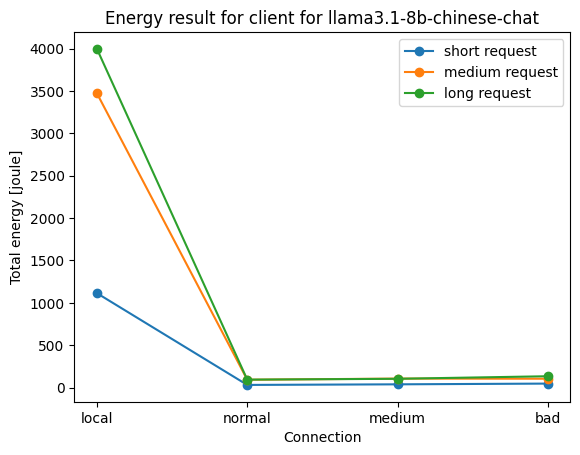

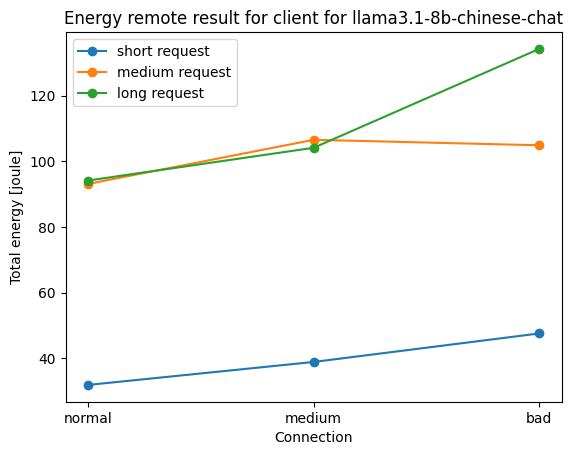

In [106]:
plot_result_mean(df_mean,'Total energy [Joule]','Energy result for client for '+ model)
plot_remote_result_mean(df_mean,'Total energy [Joule]','Energy remote result for client for '+ model)

Text(0.5, 1.0, 'Distribution for long_local for llama3.1-8b-chinese-chat')

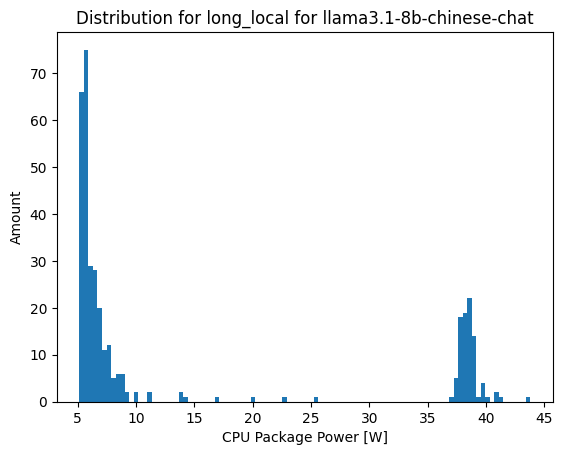

In [107]:
category='long_local'
# plt.hist(df[df['size_category']==category]['CPU Package Power [W]'],bins=15)
plt.hist(df['CPU Package Power [W]'],bins=100)
# plt.hist(df[df['size_category']=='long_normal']['Total energy [Joule]'],bins=100)
plt.xlabel('CPU Package Power [W]')
plt.ylabel('Amount')
plt.title('Distribution for '+category+ ' for '+model)


Text(0.5, 1.0, 'Distribution for long_local for llama3.1-8b-chinese-chat')

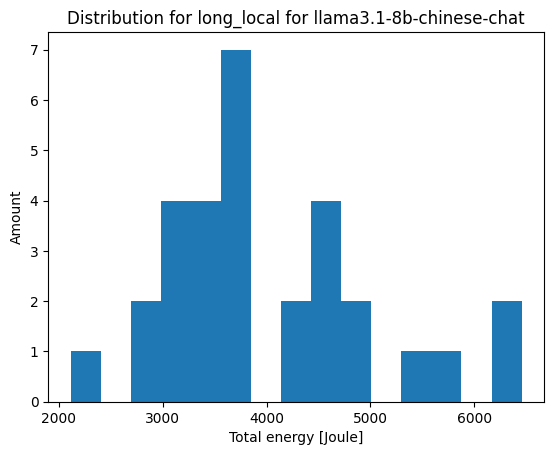

In [108]:
category='long_local'
plt.hist(df[df['size_category']==category]['Total energy [Joule]'],bins=15)
# plt.hist(df['Total energy [Joule]'],bins=100)
# plt.hist(df['Total energy [Joule]'],bins=50)
# plt.hist(df[df['size_category']=='long_normal']['Total energy [Joule]'],bins=100)
plt.xlabel('Total energy [Joule]')
plt.ylabel('Amount')
plt.title('Distribution for '+category+ ' for '+model)


In [109]:
# plt.hist(df[df['size_category']=='long_normal']['Efficiency [number_of_tokens/Joule]'],bins=15)
# plt.xlabel('Efficiency [number_of_tokens/Joule]')
# plt.ylabel('Amount')
# plt.title('Distribution for '+category+ ' for '+model)

# =====================

In [110]:
# df=client_result_filled
df=client_result
df_mean=df.groupby(['model', 'size_category']).mean()
df_mean

Virtual Memory Load [%]  \
model                       size_category                            
liquid/lfm2.5-1.2b          long_bad                     51.610000   
                            long_local                   57.436667   
                            long_medium                  46.413333   
                            long_normal                  43.113333   
                            medium_bad                   51.633333   
                            medium_local                 57.420000   
                            medium_medium                46.250000   
                            medium_normal                43.073333   
                            short_bad                    51.620000   
                            short_local                  57.480000   
                            short_medium                 46.186667   
                            short_normal                 43.110000   
llama3.1-8b-chinese-chat    long_bad                     51.620000   
                            long_local                   74.060000   
                            long_medium                  49.430000   
                            long_normal                  44.260000   
                            medium_bad                   51.630000   
                            medium_local                 74.043333   
                            medium_medium                49.463333   
                            medium_normal                44.273333   
                            short_bad                    51.636667   
                            short_local                  73.960000   
                            short_medium                 49.483333   
                            short_normal                 44.270000   
openai/gpt-oss-20b          long_bad                     51.953333   
                            long_local                   96.070000   
                            long_medium                  49.636667   
                            long_normal                  44.153333   
                            medium_bad                   51.843333   
                            medium_local                 96.143333   
                            medium_medium                49.600000   
                            medium_normal                44.146667   
                            short_bad                    51.893333   
                            short_local                  96.260000   
                            short_medium                 49.573333   
                            short_normal                 44.143333   
qwen/qwen3-4b-thinking-2507 long_bad                     51.573333   
                            long_local                   64.646667   
                            long_medium                  49.886667   
                            long_normal                  44.000000   
                            medium_bad                   51.620000   
                            medium_local                 64.676667   
                            medium_medium                49.813333   
                            medium_normal                43.936667   
                            short_bad                    51.623333   
                            short_local                  64.706667   
                            short_medium                 49.913333   
                            short_normal                 43.913333   

                                           Physical Memory Load [%]  \
model                       size_category                             
liquid/lfm2.5-1.2b          long_bad                      52.090000   
                            long_local                    63.916667   
                            long_medium                   53.523333   
                            long_normal                   47.463333   
                            medium_bad                    52.360000   
                            medium_local     

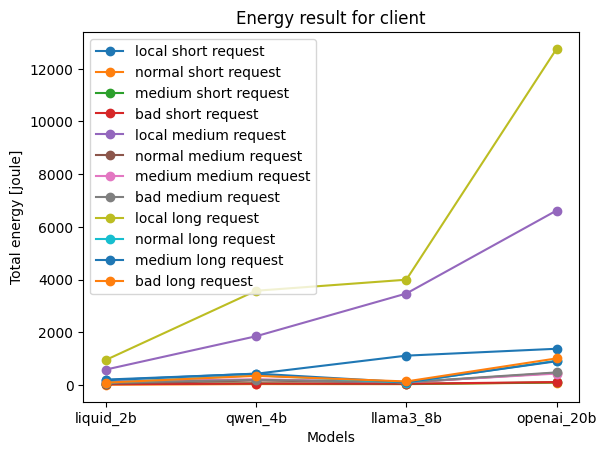

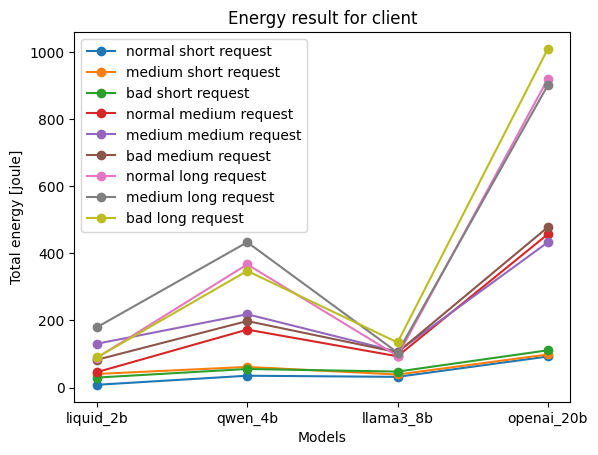

In [111]:
model_list=['liquid/lfm2.5-1.2b','qwen/qwen3-4b-thinking-2507','llama3.1-8b-chinese-chat','openai/gpt-oss-20b']
plot_result_mean_for_models(df_mean,'Total energy [Joule]',model_list,['local','normal','medium', 'bad'],'Energy result for client')
plot_result_mean_for_models(df_mean,'Total energy [Joule]',model_list,['normal','medium', 'bad'],'Energy result for client')

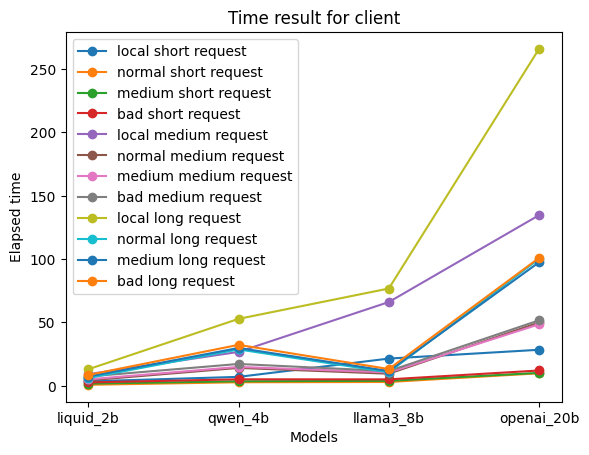

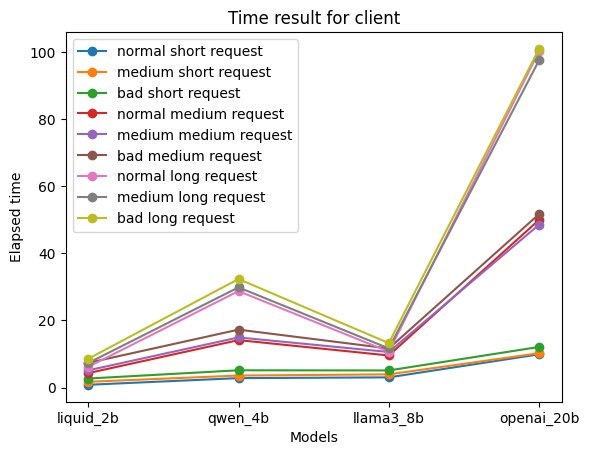

In [112]:
plot_result_mean_for_models(client_result.groupby(['model', 'size_category']).mean(),'elapsed_time',model_list,['local','normal','medium', 'bad'],'Time result for client')
plot_result_mean_for_models(client_result.groupby(['model', 'size_category']).mean(),'elapsed_time',model_list,['normal','medium', 'bad'],'Time result for client')


# =======================

In [113]:
df_server=server_result_mean
df_client=client_result_mean
# df_server=server_result_mean_filled
# df_client=client_result_mean_filled

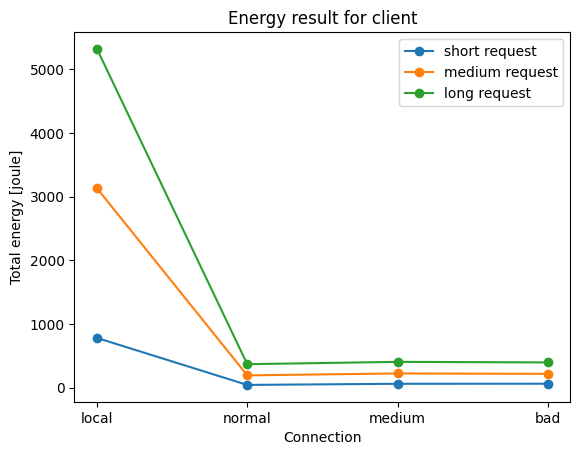

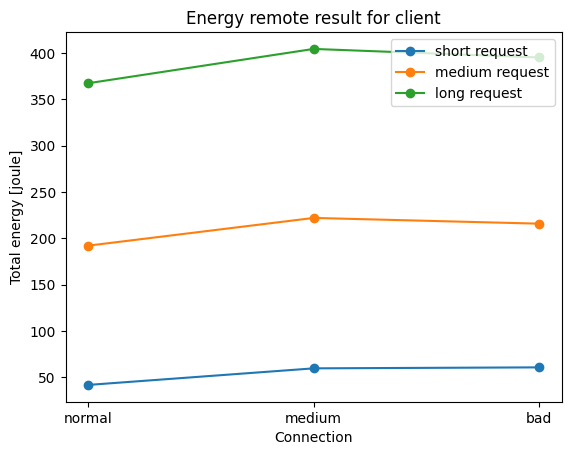

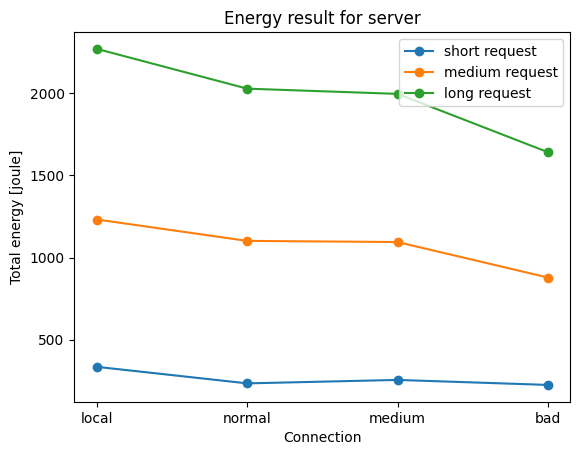

In [114]:
plot_result_mean(df_client,'Total energy [Joule]','Energy result for client')
plot_remote_result_mean(df_client,'Total energy [Joule]','Energy remote result for client')
plot_result_mean(df_server,'Total energy [Joule]','Energy result for server')

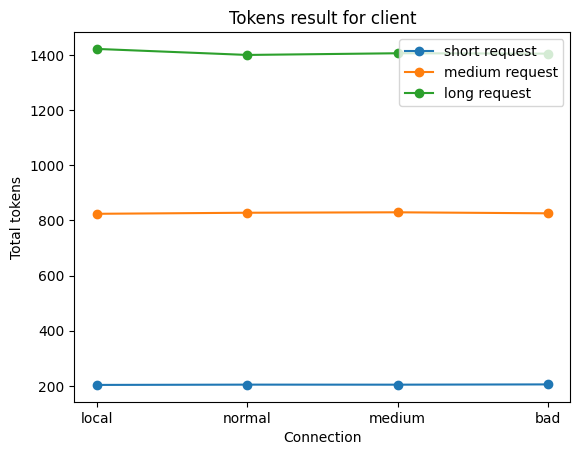

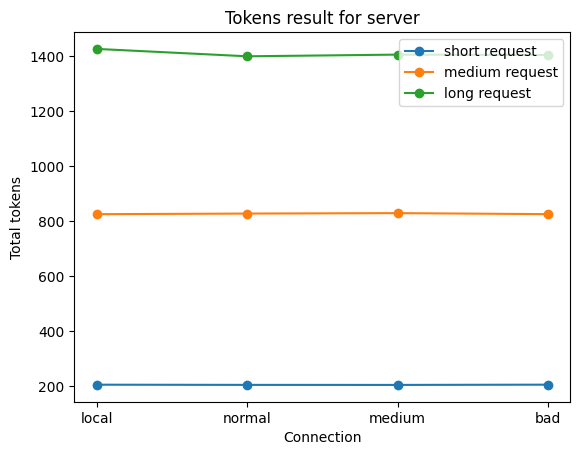

In [115]:
plot_result_mean(client_result_mean,'total_tokens','Tokens result for client')
plot_result_mean(server_result_mean,'total_tokens','Tokens result for server')

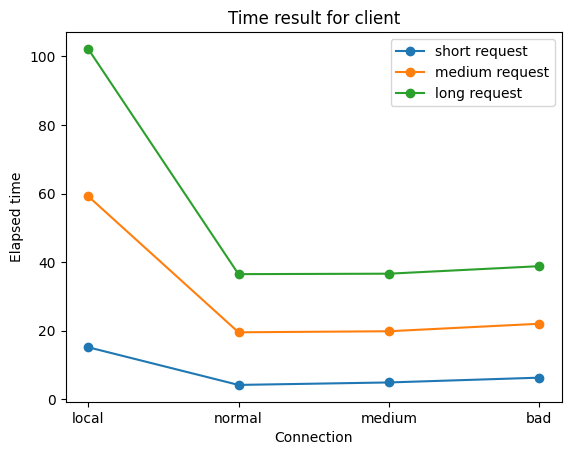

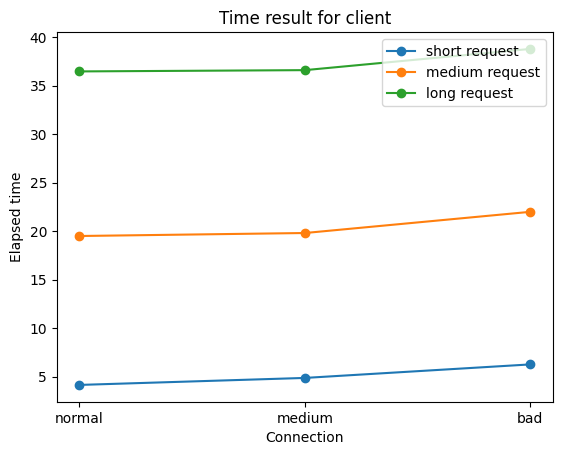

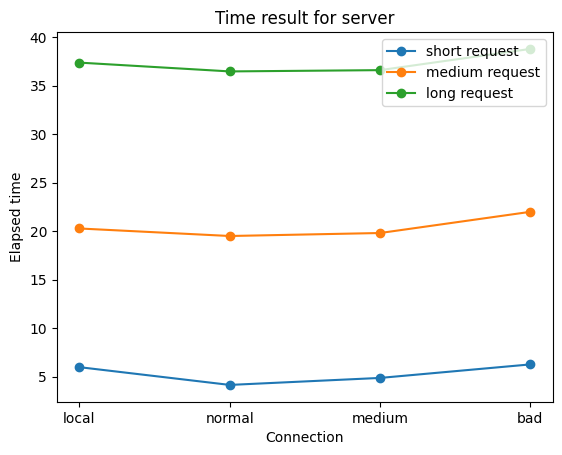

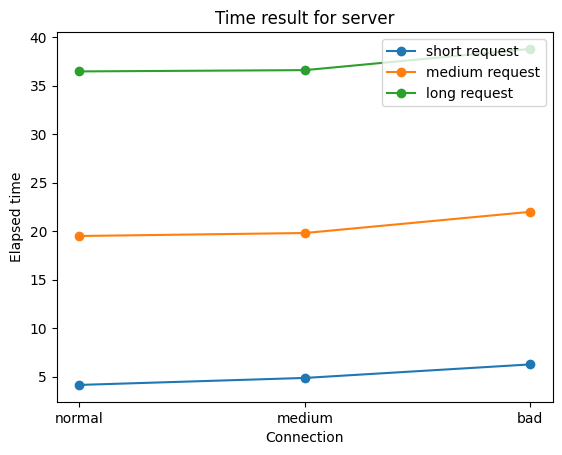

In [116]:
plot_result_mean(client_result_mean,'elapsed_time','Time result for client')
plot_remote_result_mean(client_result_mean,'elapsed_time','Time result for client')
plot_result_mean(server_result_mean,'elapsed_time','Time result for server')
plot_remote_result_mean(server_result_mean,'elapsed_time','Time result for server')

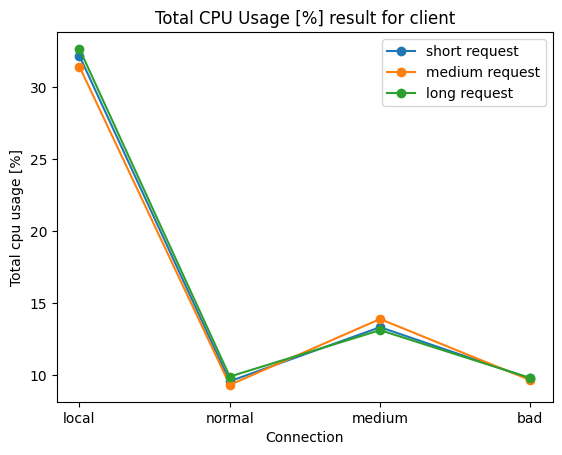

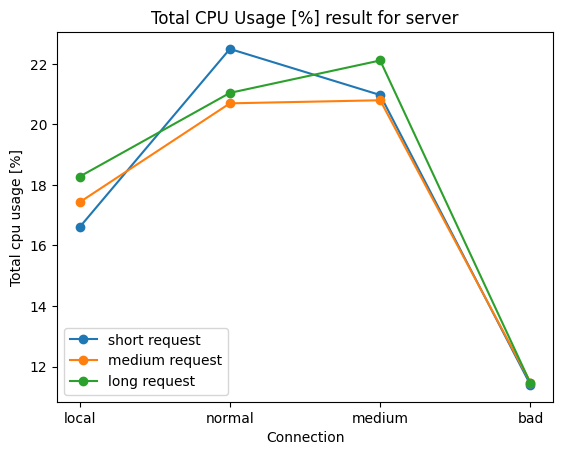

In [117]:
plot_result_mean(df_client,'Total CPU Usage [%]','Total CPU Usage [%] result for client')
plot_result_mean(df_server,'Total CPU Usage [%]','Total CPU Usage [%] result for server')

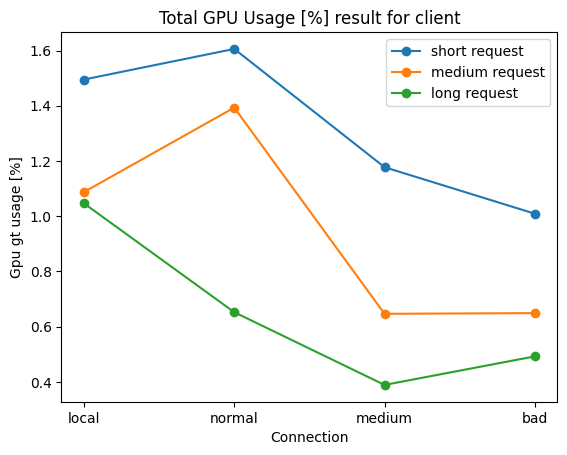

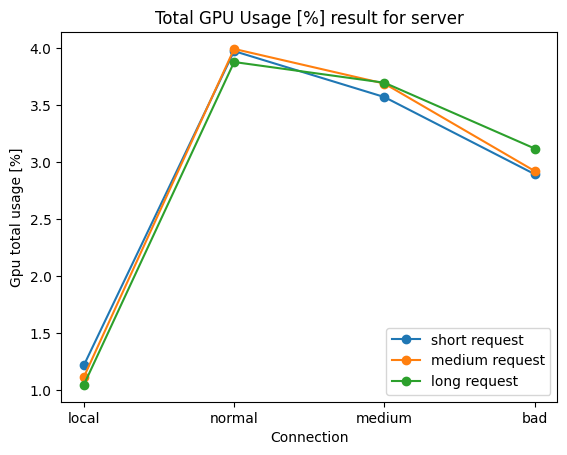

In [118]:
plot_result_mean(df_client,'GPU GT Usage [%]','Total GPU Usage [%] result for client')
plot_result_mean(df_server,'GPU Total Usage [%]','Total GPU Usage [%] result for server')

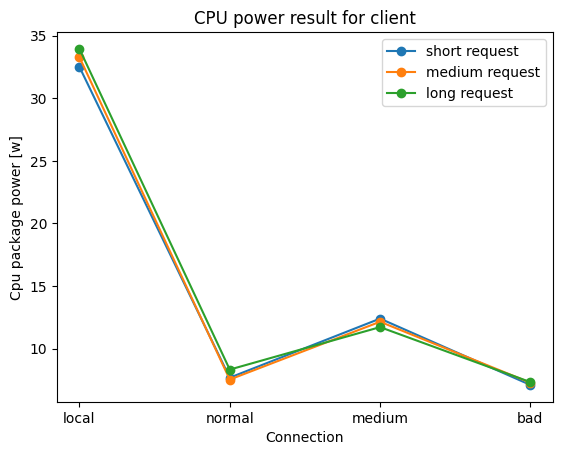

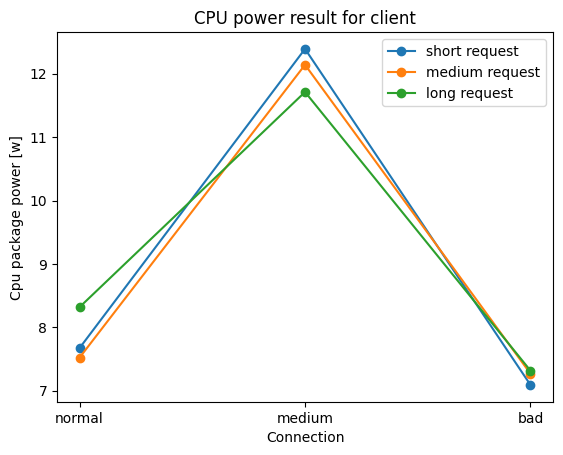

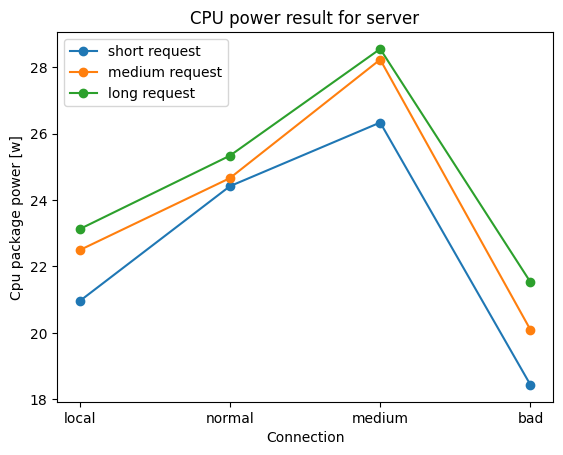

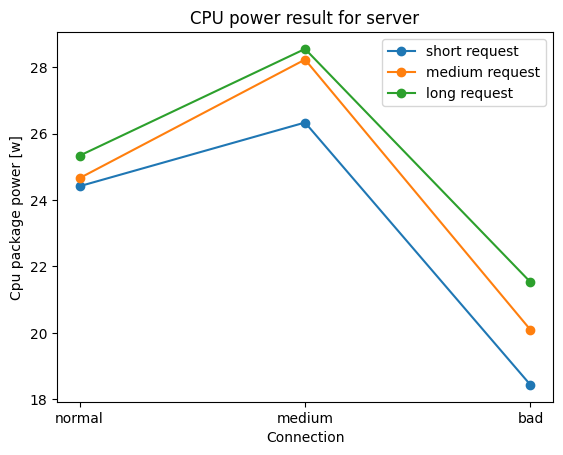

In [119]:
plot_result_mean(df_client,'CPU Package Power [W]','CPU power result for client')
plot_remote_result_mean(df_client,'CPU Package Power [W]','CPU power result for client')
plot_result_mean(df_server, 'CPU Package Power [W]','CPU power result for server')
plot_remote_result_mean(df_server, 'CPU Package Power [W]','CPU power result for server')

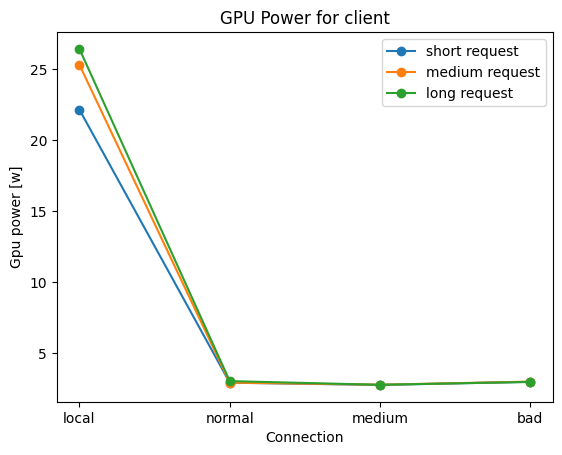

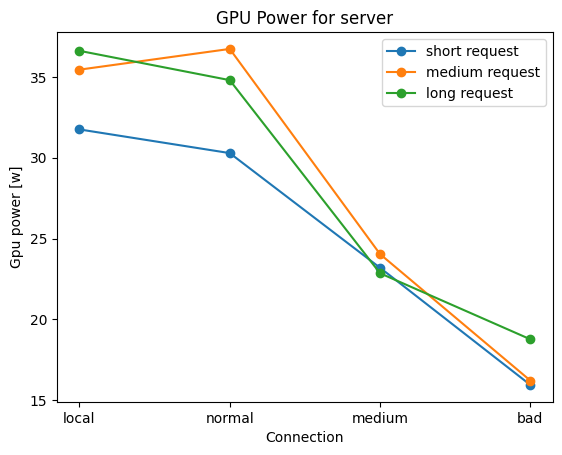

In [120]:
plot_result_mean(df_client,'GPU Power [W]','GPU Power for client')
plot_result_mean(df_server, 'GPU Power [W]','GPU Power for server')


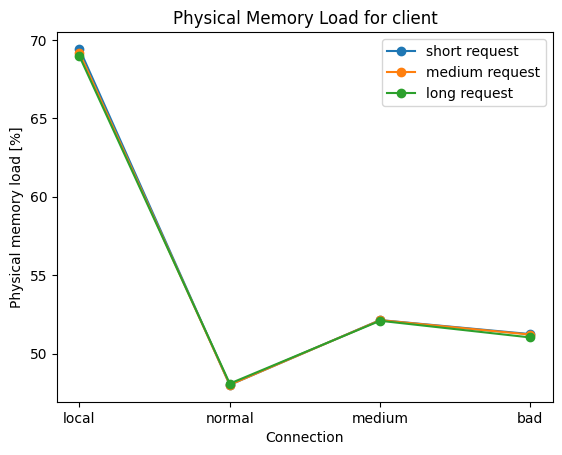

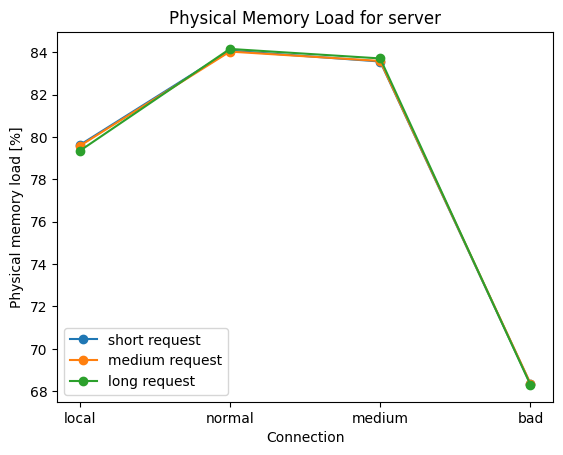

In [121]:
plot_result_mean(df_client,'Physical Memory Load [%]','Physical Memory Load for client')
plot_result_mean(df_server, 'Physical Memory Load [%]','Physical Memory Load for server')


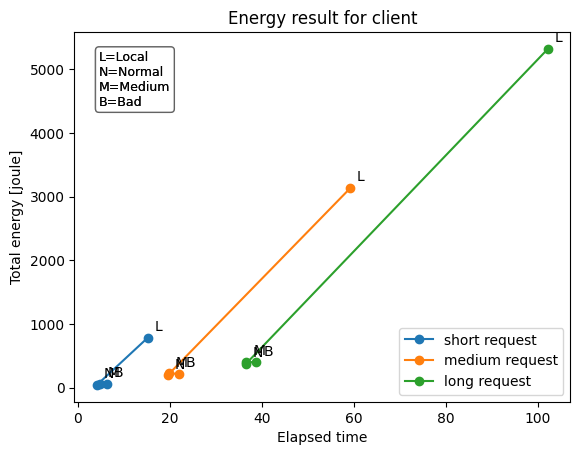

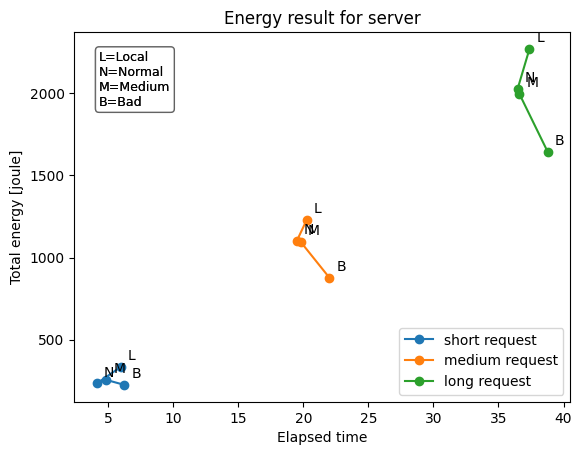

In [122]:
plot_result_mean_cross(client_result_mean,'Total energy [Joule]','elapsed_time','Energy result for client')
plot_result_mean_cross(server_result_mean,'Total energy [Joule]','elapsed_time','Energy result for server')

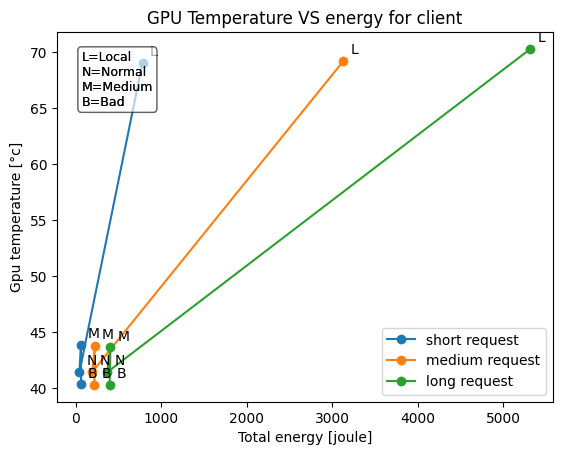

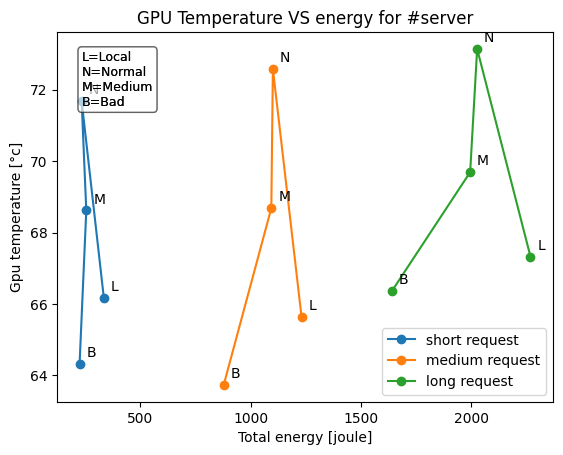

In [123]:
plot_result_mean_cross(df_client,'GPU Temperature [°C]','Total energy [Joule]','GPU Temperature VS energy for client')
plot_result_mean_cross(df_server,'GPU Temperature [°C]','Total energy [Joule]','GPU Temperature VS energy for #server')

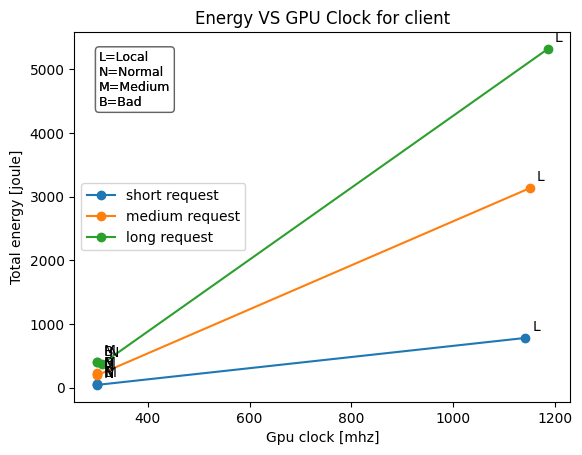

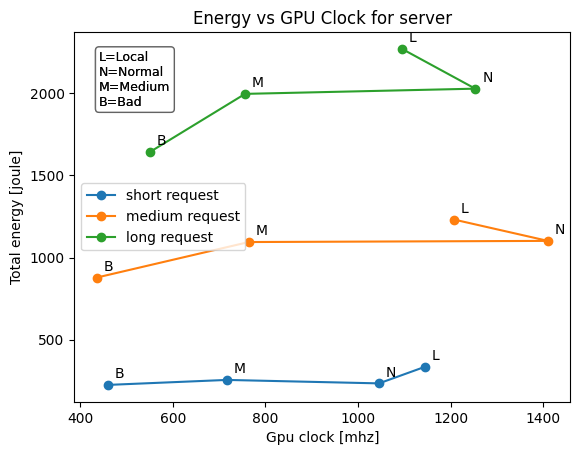

In [124]:
plot_result_mean_cross(df_client,'Total energy [Joule]','GPU Clock [MHz]','Energy VS GPU Clock for client')
plot_result_mean_cross(df_server,'Total energy [Joule]','GPU Clock [MHz]','Energy vs GPU Clock for server')

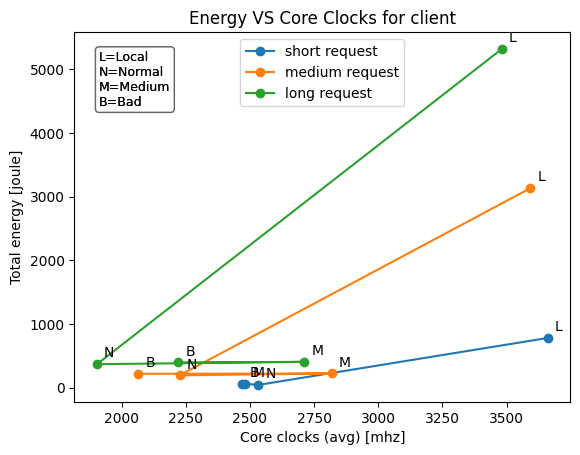

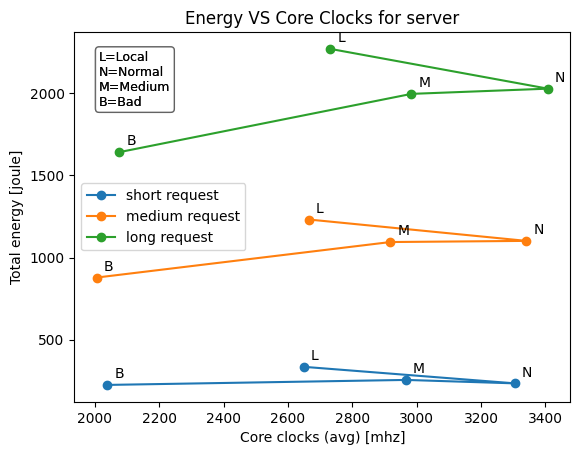

In [125]:
plot_result_mean_cross(df_client,'Total energy [Joule]','Core Clocks (avg) [MHz]','Energy VS Core Clocks for client')
plot_result_mean_cross(df_server,'Total energy [Joule]','Core Clocks (avg) [MHz]','Energy VS Core Clocks for server')

# Efficiency

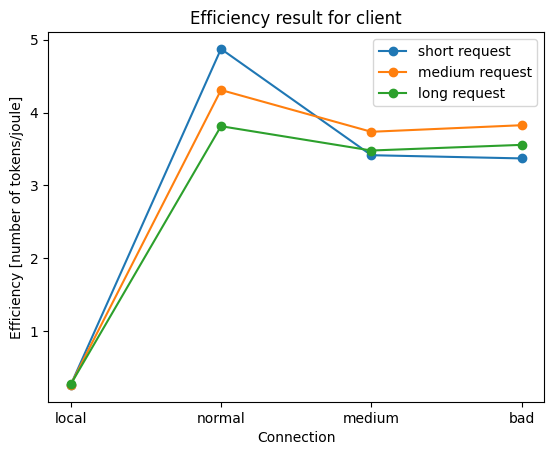

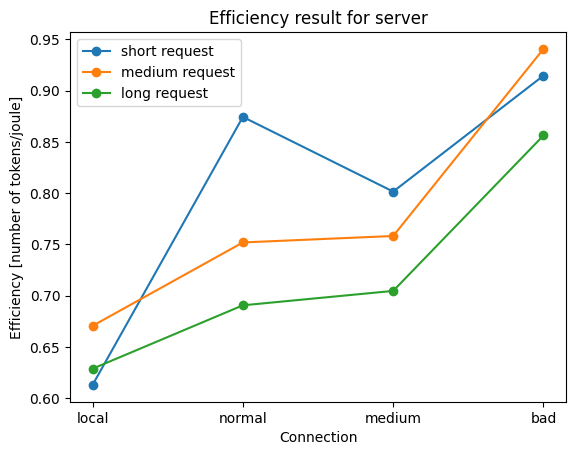

In [126]:
plot_result_mean(df_client,'Efficiency [number_of_tokens/Joule]','Efficiency result for client')
plot_result_mean(df_server,'Efficiency [number_of_tokens/Joule]','Efficiency result for server')

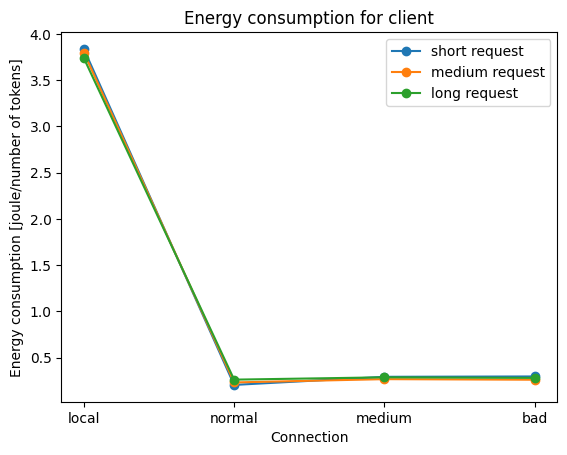

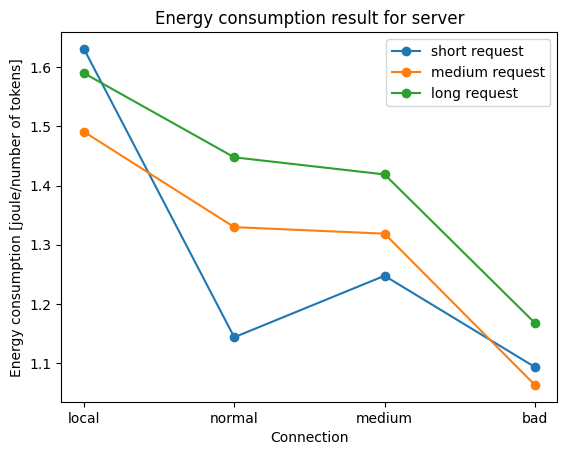

In [127]:
plot_result_mean(df_client,'Energy consumption [Joule/number_of_tokens]','Energy consumption for client')
plot_result_mean(df_server,'Energy consumption [Joule/number_of_tokens]','Energy consumption result for server')

In [128]:
df_client[['Total energy [Joule]','total_tokens','Efficiency [number_of_tokens/Joule]']]

,Total energy [Joule],total_tokens,Efficiency [number_of_tokens/Joule]
size_category,,,
long_bad,395.222484,1405.408333,3.555993
long_local,5319.837994,1422.550000,0.267405
long_medium,404.451317,1406.816667,3.478334
long_normal,367.432530,1400.691667,3.812106
medium_bad,215.914909,825.991667,3.825543
medium_local,3131.705975,824.233333,0.263190
medium_medium,222.102321,829.650000,3.735440
medium_normal,192.184161,828.075000,4.308758
short_bad,60.863577,205.108333,3.369968


In [129]:
# df= client_result
# col = "CPU Package Power [W]"

# # Индексы строк, где значение НЕ NaN
# valid_idx = df[df.notna()].index

# # Проходим по парам соседних валидных индексов
# for start, end in zip(valid_idx, valid_idx[1:]):
#     # Если между ними есть строки
#     if end - start > 1:
#         segment = df.loc[start:end, col]
#         mean_val = segment.mean()

#         # Записываем среднее в строки между start и end (не включая сами границы)
#         df.loc[start+1:end-1, col] = mean_val

In [130]:
# result_df=pd.DataFrame()

# col='CPU Package Power [W]'
# value=0
# counter=0
# was=False
# for i in range(len(df)):
#     value+=df.loc[i,col]
#     counter+=1
#     if df.loc[i].notna().all():
#         result_df=pd.concat([result_df,df.loc[i]], ignore_index=True)
#         if was:
#             result_df.loc[i-1,col]=value/counter
#         else:
#             result_df.loc[i,col]=value/counter
#         was=True
#         value=0
#         counter=0

# if counter!=0:
#     result_df.loc[-1,col]=value/counter

In [131]:
# result_df = pd.DataFrame()

# col = 'CPU Package Power [W]'

# value = 0
# counter = 0
# was=False

# for i in range(len(df)):
#     val = df.loc[i, col]

#     # накапливаем только значения CPU Package Power [W]
#     value += val
#     counter += 1

#     # если строка полностью без NaN → граница сегмента
#     if df.loc[i].notna().all():

#         mean_val = value / counter

#         # копируем строку и подменяем значение
#         row = df.loc[i].copy()
#         # row[col] = mean_val

#         # добавляем в результат
#         result_df = pd.concat([result_df, row.to_frame().T], ignore_index=True)
#         if not was:
#             result_df.loc[-2,col]=mean_val
#         was=True
#         # сбрасываем сегмент
#         value = 0
#         counter = 0

# # если датафрейм заканчивается на строках с NaN → закрываем хвост
# if counter != 0:
#     mean_val = value / counter
#     row = df.iloc[-1].copy()
#     row[col] = mean_val
#     result_df = pd.concat([result_df, row.to_frame().T], ignore_index=True)

In [136]:
df_client['PL1 Power Limit (Dynamic) [W]']

size_category
long_bad         70.000000
long_local       45.000000
long_medium      65.470833
long_normal      70.000000
medium_bad       70.000000
medium_local     45.000000
medium_medium    65.225000
medium_normal    70.000000
short_bad        70.000000
short_local      45.000000
short_medium     65.058333
short_normal     70.000000
Name: PL1 Power Limit (Dynamic) [W], dtype: float64

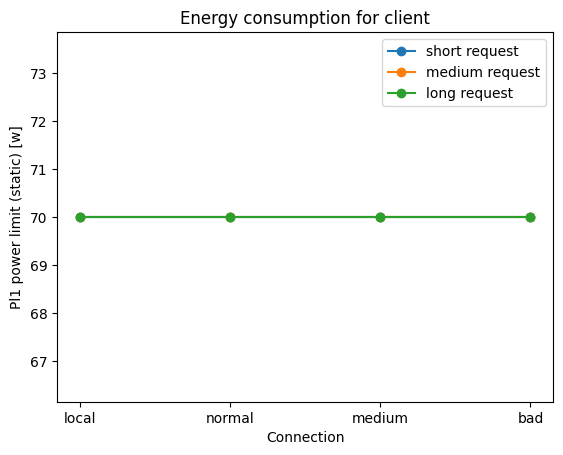

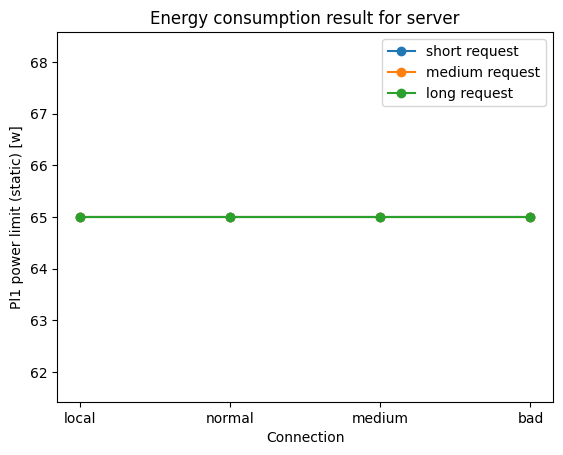

In [133]:
plot_result_mean(df_client,'PL1 Power Limit (Dynamic) [W]','Energy consumption for client')
plot_result_mean(df_server,'PL1 Power Limit (Dynamic) [W]','Energy consumption result for server')


In [134]:
client_result['PL1 Power Limit (Static) [W]']

0        70.0
1        70.0
2        70.0
3        70.0
4        70.0
         ... 
22543    70.0
22544    70.0
22545    70.0
22546    70.0
22547    70.0
Name: PL1 Power Limit (Static) [W], Length: 22548, dtype: float64

In [135]:
client_result['PL1 Power Limit (Dynamic) [W]']


0        45.0
1        45.0
2        45.0
3        45.0
4        45.0
         ... 
22543    70.0
22544    70.0
22545    70.0
22546    70.0
22547    70.0
Name: PL1 Power Limit (Dynamic) [W], Length: 22548, dtype: float64